----

**Responsáveis:**

[Alan Taranti](https://www.linkedin.com/in/alan-taranti/)

Antônio Carlos

Natan Falbo

[Renato Canegusuco](https://www.linkedin.com/in/renato-canegusuco-akamine/)


**Orientadores:**

Marcelo L. Perucci

Ricardo Tomita

----

O objetivo do presente trabalho consistem verificar quais empresas de PEPs (Pessoas Politicamente Expostas) que receberam recursos dos próprios municípios em que têm mandatos.

Para isso serão utilizado dados do Portal de Transparência Municipal do TCESP, base de dados públicos de CNPJ da SRF e dados do Portal da Transparência da CGU.

**Atenção:** Como o presente trabalho é para fins educacionais, os nomes, CPFs e CNPJs foram alterados, mas as estruturas são idênticas às das tabelas originais.

# Importar as bibliotecas utilizadas

In [1]:
import os
import shutil

import folium
import pandas as pd
import sqlalchemy
import seaborn as sns

# Carregar Dados

In [2]:
diretorio_dados = 'dados'

## Carregar dados de banco

O banco de dados possui três tabelas: despesas_consolidado, empresas e sócios

In [3]:
arquivo_sqlite = 'banco_trabalho06.db'
filepath_arquivo_sqlite = os.path.join(diretorio_dados, arquivo_sqlite)

In [4]:
url_banco = "sqlite:///{}".format(filepath_arquivo_sqlite)
engine = sqlalchemy.create_engine(url_banco)

### Despesas 
É a totalização de valores pagos a empresas por município, valores aproximadamente acima de 100 mil reais.

A consolidação foi realizada a partir da tabela despesas do TCE/SP. Os nomes de empresas, cnpjs e municípios foram alterados.

A coluna **ds_municipio** é o nome do município fictício, **nr_identificador_despesa** o CNPJ da empresa que recebeu o valor da coluna soma e **ds_despesa** a razão social fictícia da empresa.

Os dados originais podem ser obtidos em: https://transparencia.tce.sp.gov.br/conjunto-de-dados

In [5]:
sql = 'SELECT * FROM despesas_consolidado'
despesas = pd.read_sql(sql, engine, index_col=None)

Aqui podemos visualizar uma amostra dos dados

In [6]:
despesas.sample(5)

,ds_municipio,nr_identificador_despesa,ds_despesa,soma
23837,BAITALA,68181194000113,HINA AGROPECUARIA EPP,121690.71
14692,BETIOLLO,48317372000192,RILEY CONSTRUCAO LTDA,240670.31
1179,INFANTINI,24400332000116,GRACE BRASIL LTDA,3762219.51
10529,ZACCAI,15348177000170,AITOR COMERCIO,329113.64
18166,MANGIARINI,14804708000174,BENTO EQUIPAMENTOS,157424.82


Com o comando abaixo, podemos ver que a tabela possui 25.885 registros; não possui dados nulos e há apenas uma coluna com dados numéricos.

In [7]:
despesas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25885 entries, 0 to 25884
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ds_municipio              25885 non-null  object 
 1   nr_identificador_despesa  25885 non-null  object 
 2   ds_despesa                25885 non-null  object 
 3   soma                      25885 non-null  float64
dtypes: float64(1), object(3)
memory usage: 809.0+ KB


#### Múnicipios Únicos

In [8]:
municipios_sao_paulo = 645
quantidade_municipios_unicos = len(despesas['ds_municipio'].unique())
proporcao = round(quantidade_municipios_unicos/municipios_sao_paulo*100,1)

print('O estado de São Paulo possui {} municipios'.format(municipios_sao_paulo))
print('A amostra utilizada, possui {} municipios unicos'.format(quantidade_municipios_unicos))
print('Representando {}% dos municipios de SP'.format(proporcao))

O estado de São Paulo possui 645 municipios
A amostra utilizada, possui 644 municipios unicos
Representando 99.8% dos municipios de SP


#### Distribuição Despesas Município

[Text(0.5, 0, 'Despesas'), Text(0, 0.5, 'Contagem')]

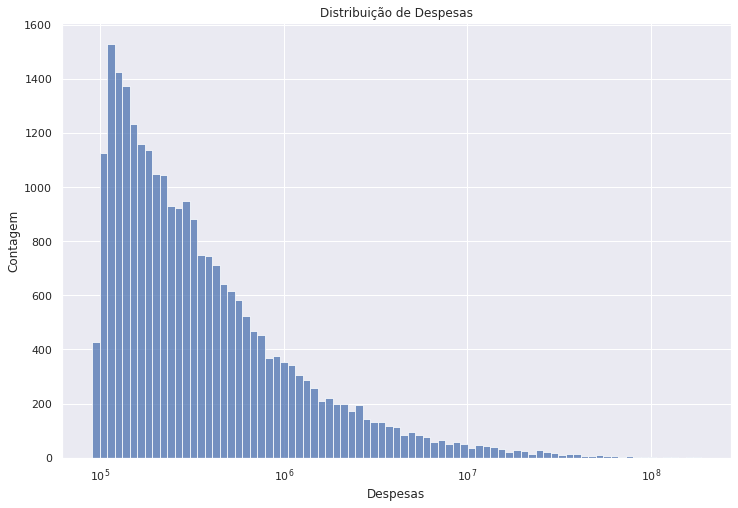

In [9]:
sns.set(rc={'figure.figsize':(12, 8)})

ax = sns.histplot(despesas, x='soma', log_scale=True)

ax.set(title='Distribuição de Despesas')
ax.set(xlabel='Despesas', ylabel='Contagem')

#### Municípios Que Mais Gastaram

In [10]:
municipios_despesas = despesas.groupby('ds_municipio').sum()
municipios_despesas = municipios_despesas.sort_values('soma', ascending=False)
top_10_municipio_despesas = municipios_despesas.head(10).reset_index()

In [11]:
top_10_municipio_despesas

,ds_municipio,soma
0,ROZARIO,1.223180e+09
1,DALAGO,9.643243e+08
2,HELFER,9.434388e+08
3,ZACCAI,9.342326e+08
4,HOLZBACH,7.990991e+08
5,PROITE,7.534733e+08
6,POVINHA,7.382816e+08
7,PATELLI,6.120559e+08
8,MARTEL,6.112997e+08
9,KANDELMAN,5.709025e+08


[Text(0.5, 0, 'Despesas'), Text(0, 0.5, 'Município')]

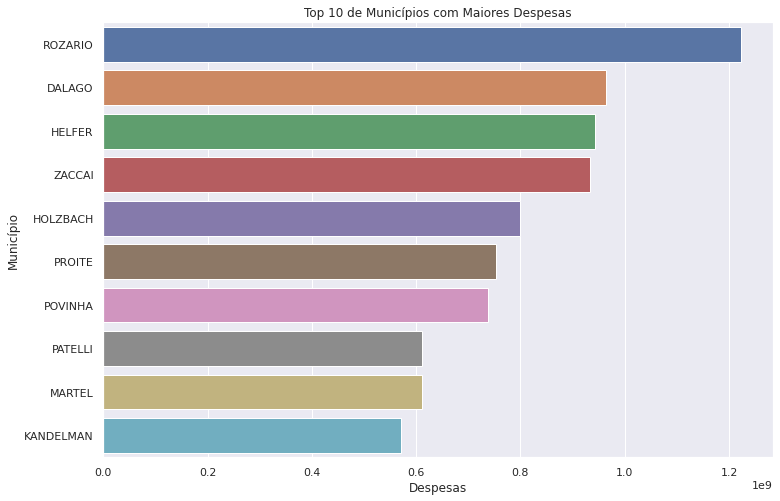

In [12]:
ax = sns.barplot(data=top_10_municipio_despesas, x='soma', y='ds_municipio')

ax.set(title='Top 10 de Municípios com Maiores Despesas')
ax.set(xlabel='Despesas', ylabel='Município')

### Empresas 
Tabela de empresas da receita federal.

Possui dados alterados, mas a estrutura das colunas é semelhante a base pública da Receita Federal.

Os dados originais podem ser obtidos em: https://www.gov.br/receitafederal/pt-br/assuntos/orientacao-tributaria/cadastros/consultas/dados-publicos-cnpj

In [13]:
sql = 'SELECT * FROM empresas'
empresas = pd.read_sql(sql, engine, index_col=None)

Aqui podemos visualizar uma amostra dos dados

In [14]:
empresas.sample(5)

,cnpj,matriz_filial,razao_social,nome_fantasia,situacao,data_situacao,motivo_situacao,nm_cidade_exterior,cod_pais,nome_pais,...,email,qualif_resp,capital_social,porte,opc_simples,data_opc_simples,data_exc_simples,opc_mei,sit_especial,data_sit_especial
166,36383598000193,1,NICOLE PECAS,,02,20200101,00,,,,...,,,4.811773e+07,03,0,,,N,,
2043,23828817000114,1,LEANDRO ADMINISTRATIVO,,02,20200101,01,,,,...,,,1.283139e+06,01,6,,,N,,
2194,12681062000178,1,ALEXANDRA CONTABILIDADE LTDA,,02,20200101,00,,,,...,,,2.749585e+06,01,5,,,N,,
197,69455671000128,1,CSABA INDUSTRIAIS,,02,20200101,01,,,,...,,,0.000000e+00,05,0,,,N,,
2527,07768055000141,1,ILYES DTVM EIRELLI,,02,20200101,00,,,,...,,,0.000000e+00,03,0,,,N,,


Com o comando abaixo, podemos ver que a tabela possui 5.779 registros; não possui dados nulos e há apenas uma coluna com dados numéricos.

In [15]:
empresas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5779 entries, 0 to 5778
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cnpj                5779 non-null   object 
 1   matriz_filial       5779 non-null   object 
 2   razao_social        5779 non-null   object 
 3   nome_fantasia       5779 non-null   object 
 4   situacao            5779 non-null   object 
 5   data_situacao       5779 non-null   object 
 6   motivo_situacao     5779 non-null   object 
 7   nm_cidade_exterior  5779 non-null   object 
 8   cod_pais            5779 non-null   object 
 9   nome_pais           5779 non-null   object 
 10  cod_nat_juridica    5779 non-null   object 
 11  data_inicio_ativ    5779 non-null   object 
 12  cnae_fiscal         5779 non-null   object 
 13  tipo_logradouro     5779 non-null   object 
 14  logradouro          5779 non-null   object 
 15  numero              5779 non-null   object 
 16  comple

#### Sócios
Tabela de sócios da receita federal.

Possui dados alterados, mas a estrutura das colunas é semelhante a base pública da Receita Federal.

Os dados originais podem ser obtidos em: https://www.gov.br/receitafederal/pt-br/assuntos/orientacao-tributaria/cadastros/consultas/dados-publicos-cnpj

In [16]:
sql = 'SELECT * FROM socios'
socios = pd.read_sql(sql, engine, index_col=None)

Aqui podemos visualizar uma amostra dos dados

In [17]:
socios.sample(5)

,cnpj,tipo_socio,nome_socio,cnpj_cpf_socio,cod_qualificacao,perc_capital,data_entrada,cod_pais_ext,nome_pais_ext,cpf_repres,nome_repres,cod_qualif_repres
1549,64482439001975,2,DILADOR LANUZIA NEUWIEM,***766376**,49,0.0,20200101,,,,,00
5787,03461442000134,2,PECENE MACELANI EPSON FILHO,***112758**,49,0.0,20200101,,,,,00
1094,08606115000192,2,UNAIDE GRIZOLIA,***801308**,16,0.0,20200101,,,,,00
1776,52308307000179,2,BIANCK DELBRANTINO PALAZIM CALZADA,***017288**,16,0.0,20200101,,,,,00
403,01866223000264,2,ANA DAZZI LAUVRS FEDUMENTI,***737538**,59,0.0,20200101,,,,,00


Com o comando abaixo, podemos ver que a tabela possui 5.825 registros; não possui dados nulos e há apenas uma coluna com dados numéricos.

In [18]:
socios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5825 entries, 0 to 5824
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cnpj               5825 non-null   object 
 1   tipo_socio         5825 non-null   object 
 2   nome_socio         5825 non-null   object 
 3   cnpj_cpf_socio     5825 non-null   object 
 4   cod_qualificacao   5825 non-null   object 
 5   perc_capital       5825 non-null   float64
 6   data_entrada       5825 non-null   object 
 7   cod_pais_ext       5825 non-null   object 
 8   nome_pais_ext      5825 non-null   object 
 9   cpf_repres         5825 non-null   object 
 10  nome_repres        5825 non-null   object 
 11  cod_qualif_repres  5825 non-null   object 
dtypes: float64(1), object(11)
memory usage: 546.2+ KB


## Carregar dados de Pessoas Expostas Politicamente
As Pessoas Expostas Politicamente são os agentes públicos que desempenham ou tenham desempenhado, nos cinco anos anteriores, no Brasil ou em países, territórios e dependências estrangeiros, cargos, empregos ou funções públicas relevantes, assim como seus representantes, familiares e outras pessoas de seu relacionamento próximo.

Possui dados alterados, mas a estrutura das colunas é semelhante a base pública do Portal da Transparência.

O arquivo original pode ser obtido em http://www.portaldatransparencia.gov.br/download-de-dados/pep

In [19]:
arquivo_peps = 'PEP_SP.csv'
filepath_arquivo_pep = os.path.join(diretorio_dados, arquivo_peps)

In [20]:
peps = pd.read_csv(filepath_arquivo_pep, sep=';')

Aqui podemos visualizar uma amostra dos dados

In [21]:
peps.sample(5)

,CPF,Nome_PEP,Sigla_Função,Descrição_Função,Nível_Função,Nome_Órgão,Data_Início_Exercício,Data_Fim_Exercício,Data_Fim_Carência,uf_orgao
4469,***.573.598-**,CAUME RAPPO DE MILANEZZI PRANTEL,VEREAD,VEREADOR,NaN,MUN. DE NEDEHER-SP,01/01/2017,31/12/2020,31/12/2025,SP
2140,***.263.548-**,TAREK CATONHO,PREFEI,PREFEITO,NaN,MUN. DE VIRGULINO-SP,01/01/2017,31/12/2020,31/12/2025,SP
3148,***.388.458-**,GUSTAVO TIERSON HISSAN,PREFEI,PREFEITO,NaN,MUN. DE MANCEN-SP,01/01/2017,31/12/2020,31/12/2025,SP
782,***.097.458-**,JOAO FLAVIO SILIS,VEREAD,VEREADOR,NaN,MUN. DE IAFELIX-SP,01/01/2017,31/12/2020,31/12/2025,SP
4445,***.570.808-**,ALEXANDRE BONAVOGLIA GONDOREK DE AUDERLEIDE,VEREAD,VEREADOR,NaN,MUN. DE BUCATER-SP,01/01/2017,31/12/2020,31/12/2025,SP


Com o comando abaixo, podemos ver que a tabela possui 7.690 registros; possui apenas o coluna **Nível_Função** com dados nulos.

In [22]:
peps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7690 entries, 0 to 7689
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    7690 non-null   object 
 1   Nome_PEP               7690 non-null   object 
 2   Sigla_Função           7690 non-null   object 
 3   Descrição_Função       7690 non-null   object 
 4   Nível_Função           0 non-null      float64
 5   Nome_Órgão             7690 non-null   object 
 6   Data_Início_Exercício  7690 non-null   object 
 7   Data_Fim_Exercício     7690 non-null   object 
 8   Data_Fim_Carência      7690 non-null   object 
 9   uf_orgao               7690 non-null   object 
dtypes: float64(1), object(9)
memory usage: 600.9+ KB


### Contagem de PEPs por Função

[Text(0.5, 0, 'Função'), Text(0, 0.5, 'Contagem')]

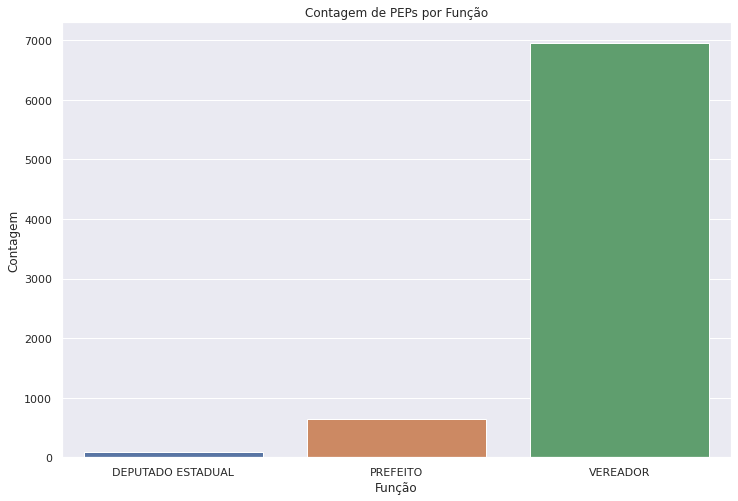

In [23]:
ax = sns.countplot(data=peps.sort_values('Descrição_Função'), x='Descrição_Função')

ax.set(title='Contagem de PEPs por Função')
ax.set(xlabel='Função', ylabel='Contagem')

# Execução

In [24]:
# Definir diretorio saida
diretorio_saida_dados = 'saida'

# Remover diretorio saida, se houver
shutil.rmtree(diretorio_saida_dados, ignore_errors=True)

# Criar diretorio saida
os.makedirs(diretorio_saida_dados, exist_ok=True)

## Tratamento dos dados

Alguns dados precisam ser tratados antes da análise.

### Empresa

A coluna **data_situacao** está no formato YYYMMDD, para facilitar a análise, vamos criar a coluna **data_situacao_normalizado** com o formato YYYY-MM-DD

In [25]:
empresas['data_situacao'].sample(5)

2342    20200101
2537    20200101
3138    20200101
4498    20200101
3818    20200101
Name: data_situacao, dtype: object

In [26]:
empresas['data_situacao_normalizado'] = pd.to_datetime(empresas['data_situacao']).dt.date

In [27]:
empresas['data_situacao_normalizado'].sample(5)

5050    2020-01-01
2511    2020-01-01
3878    2020-01-01
5253    2020-01-01
5531    2020-01-01
Name: data_situacao_normalizado, dtype: object

### Socios

A coluna **data_entrada** está no formato YYYMMDD, para facilitar a análise, vamos criar a coluna **data_entrada_normalizado** com o formato YYYY-MM-DD

In [28]:
socios['data_entrada'].sample(5)

4340    20200101
4452    20200101
2233    20200101
572     20200101
5820    20200101
Name: data_entrada, dtype: object

In [29]:
socios['data_entrada_normalizado'] = pd.to_datetime(socios['data_entrada']).dt.date

In [30]:
socios['data_entrada_normalizado'].sample(5)

2505    2020-01-01
1730    2020-01-01
971     2020-01-01
1342    2020-01-01
3367    2020-01-01
Name: data_entrada_normalizado, dtype: object

### Pessoas Politicamente Expostas

A coluna **CPF** possuem pontuação, vamos criar a coluna **CPF_normalizado** sem elas.

In [31]:
peps['CPF'].sample(5)

6070    ***.782.479-**
1603    ***.194.198-**
3785    ***.482.908-**
2431    ***.300.288-**
1051    ***.132.548-**
Name: CPF, dtype: object

In [32]:
peps['CPF_normalizado'] = peps['CPF'].str.replace(".", "", regex=False).str.replace("-", "", regex=False)

In [33]:
peps['CPF_normalizado'].sample(5)

2521    ***308478**
7402    ***961078**
7413    ***963338**
7464    ***970368**
2735    ***331768**
Name: CPF_normalizado, dtype: object

Na coluna **Nome_Órgão** vamos filtrar dados extras e manter apenas o nome do município na coluna **Municipio_normalizado**

In [34]:
peps['Nome_Órgão'].sample(5)

4583       MUN. DE HIROMORI-SP
6439          MUN. DE NEROS-SP
6781            MUN. DE ZYS-SP
3001        MUN. DE GARDUSI-SP
6591    MUN. DE BREITSCHAFT-SP
Name: Nome_Órgão, dtype: object

In [35]:
peps['Municipio_normalizado'] = peps['Nome_Órgão'].str.replace("MUN. DE ", "", regex=False).str.replace("-SP", "", regex=False)

In [36]:
peps['Municipio_normalizado'].sample(5)

4307      UJIHARA
2438    IZAGUIRRE
1810      BAITALA
1328         VITT
2475        MINFU
Name: Municipio_normalizado, dtype: object

As coluna **Data_Início_Exercício**, **Data_Fim_Exercício** e **Data_Fim_Carência** estão no formato YYYY/MM/DD, para facilitar a análise, vamos criar a colunas **Data_Inicio_Exercicio_normalizado**, **Data_Fim_Exercicio_normalizado** e **Data_Fim_Carência_normalizado** com o formato YYYY-MM-DD

In [37]:
peps['Data_Início_Exercício'].sample(5)

3126    01/01/2017
4520    01/01/2017
7431    01/01/2017
3733    01/01/2017
3074    01/01/2017
Name: Data_Início_Exercício, dtype: object

In [38]:
peps['Data_Fim_Exercício'].sample(5)

7039    31/12/2018
5386    31/12/2020
5693    31/12/2020
4673    31/12/2020
1011    31/12/2020
Name: Data_Fim_Exercício, dtype: object

In [39]:
peps['Data_Fim_Carência'].sample(5)

536     31/12/2025
2780    31/12/2025
3787    31/12/2025
5026    31/12/2025
5943    31/12/2025
Name: Data_Fim_Carência, dtype: object

In [40]:
peps['Data_Inicio_Exercicio_normalizado'] = pd.to_datetime(peps['Data_Início_Exercício']).dt.date
peps['Data_Fim_Exercicio_normalizado'] = pd.to_datetime(peps['Data_Fim_Exercício']).dt.date
peps['Data_Fim_Carência_normalizado'] = pd.to_datetime(peps['Data_Fim_Carência']).dt.date

In [41]:
peps['Data_Inicio_Exercicio_normalizado'].sample(5)

1880    2017-01-01
7636    2017-01-01
89      2017-01-01
4866    2017-01-01
5567    2017-01-01
Name: Data_Inicio_Exercicio_normalizado, dtype: object

In [42]:
peps['Data_Fim_Exercicio_normalizado'].sample(5)

4019    2020-12-31
5357    2020-12-31
4710    2020-12-31
3193    2020-12-31
5173    2020-12-31
Name: Data_Fim_Exercicio_normalizado, dtype: object

In [43]:
peps['Data_Fim_Carência_normalizado'].sample(5)

3461    2025-12-31
1530    2025-12-31
1573    2025-12-31
4339    2025-12-31
1259    2025-12-31
Name: Data_Fim_Carência_normalizado, dtype: object

## Gerar Banco de Dados

### Copiar banco original para diretorio de saida

In [44]:
arquivo_banco_saida = 'output.db'
filepath_arquivo_banco_saida = os.path.join(diretorio_saida_dados, arquivo_banco_saida)
shutil.copyfile(filepath_arquivo_sqlite, filepath_arquivo_banco_saida)

'saida/output.db'

### Gravar tabela de prefeitos_vereadores em banco gerado

In [45]:
url_banco = "sqlite:///{}".format(filepath_arquivo_banco_saida)
engine_banco_saida = sqlalchemy.create_engine(url_banco)

In [46]:
peps.to_sql('peps', con=engine_banco_saida)

## Consultar Empresas Relacionadas com Pessoas Politicamente Expostas que Receberam Recursos

In [47]:
sql = 'SELECT \
  des.ds_municipio AS [Nome_Municipio_Ficticio], \
  des.nr_identificador_despesa AS [CNPJ_Empresa_Beneficiaria], \
  des.ds_despesa AS [Razao_Social_Empresa_Beneficiaria], \
  des.soma AS [Valor_Total], \
  emp.cnpj AS [CNPJ_RFB], \
  emp.razao_social AS [Razao_Social_RFB], \
  CASE emp.situacao \
    WHEN "01" THEN "NULA" \
    WHEN "02" THEN "ATIVA" \
    WHEN "03" THEN "SUSPENSA" \
    WHEN "04" THEN "INAPTA" \
    WHEN "08" THEN "BAIXADA" \
  END AS [Situacao_Cadastral_RFB], \
  CAST(emp.data_situacao AS DATE) AS [Data_Situacao_Cadastral_RFB], \
  emp.cod_nat_juridica AS [Codigo_Natureza_Juridica_RFB], \
  CAST(emp.data_inicio_ativ AS DATE) AS [Data_Inicio_Atividade_RFB], \
  emp.cnae_fiscal AS [CNAE_Fiscal_RFB], \
  emp.municipio AS [Municipio_RFB], \
  emp.uf AS [UF_RFB], \
  soc.nome_socio AS [Nome_Socio_RFB], \
  soc.cnpj_cpf_socio AS [CPF_Socio_RFB], \
  CAST(soc.data_entrada AS DATE) AS [Data_Entrada_Socio_RFB], \
  pep.Nome_PEP AS [Nome_PEP], \
  pep.CPF_normalizado AS [CPF_PEP], \
  pep.Descrição_Função AS [Funcao_PEP], \
  pep.Data_Inicio_Exercicio_normalizado AS [Data_Inicio_PEP], \
  pep.Data_Fim_Exercicio_normalizado AS [Data_Fim_PEP], \
  pep.Data_Fim_Carência_normalizado AS [Data_Carencia_PEP], \
  pep.Municipio_normalizado AS [Municipio_PEP], \
  pep.uf_orgao AS [UF_PEP] \
FROM despesas_consolidado des \
JOIN empresas emp ON emp.cnpj = des.nr_identificador_despesa \
JOIN socios soc ON soc.cnpj = emp.cnpj \
JOIN peps pep ON pep.CPF_normalizado = soc.cnpj_cpf_socio AND pep.Nome_PEP = soc.nome_socio'

In [48]:
empresas_peps = pd.read_sql(sql, engine_banco_saida, index_col=None)

In [49]:
empresas_peps.sample(5)

,Nome_Municipio_Ficticio,CNPJ_Empresa_Beneficiaria,Razao_Social_Empresa_Beneficiaria,Valor_Total,CNPJ_RFB,Razao_Social_RFB,Situacao_Cadastral_RFB,Data_Situacao_Cadastral_RFB,Codigo_Natureza_Juridica_RFB,Data_Inicio_Atividade_RFB,...,CPF_Socio_RFB,Data_Entrada_Socio_RFB,Nome_PEP,CPF_PEP,Funcao_PEP,Data_Inicio_PEP,Data_Fim_PEP,Data_Carencia_PEP,Municipio_PEP,UF_PEP
7,ESTRUTTI,55815300000475,AMINE IMOBILIARIOS,978748.92,55815300000475,AMINE IMOBILIARIOS,ATIVA,20200101,3999,20111019,...,***890658**,20200101,AMARILDO SABATE KAILER,***890658**,PREFEITO,2017-01-01,2020-12-31,2025-12-31,SOLIZ,SP
21,KASTROPIL,69669464000188,MARTINA ENGENHARIA EPP,423179.55,69669464000188,MARTINA ENGENHARIA EPP,ATIVA,20200101,2062,19910518,...,***023398**,20200101,UNAIDE ALBERTO CALIANDRA,***023398**,PREFEITO,2017-01-01,2020-12-31,2025-12-31,UJIHARA,SP
29,PATRUCCO,12480500000115,VICENTE MODAS,306932.06,12480500000115,VICENTE MODAS,BAIXADA,20200101,2305,20140218,...,***178358**,20200101,JOAO YPEI DE KAARA,***178358**,PREFEITO,2017-01-01,2020-12-31,2025-12-31,GAZETA,SP
49,CAPIOTTI,10240793000137,JOAO LUCAS ELETRONICOS SA,147613.61,10240793000137,JOAO LUCAS ELETRONICOS SA,ATIVA,20200101,3999,20130111,...,***502138**,20200101,CAUME UNAIDE ABASILIA PHREDERICO ZIELAK,***502138**,PREFEITO,2017-01-01,2020-12-31,2025-12-31,BREIA,SP
3,POSE,03195017000178,JONA SPE,8875293.18,03195017000178,JONA SPE,ATIVA,20200101,2240,20200423,...,***294438**,20200101,TOSHIO MARIOSI,***294438**,PREFEITO,2017-01-01,2020-12-31,2025-12-31,SUCHOBKOW,SP


### Visualização

#### Quantidade de Repasses à Empresas Relacionadas à PEPs por Função

[Text(0.5, 0, 'Função'), Text(0, 0.5, 'Contagem')]

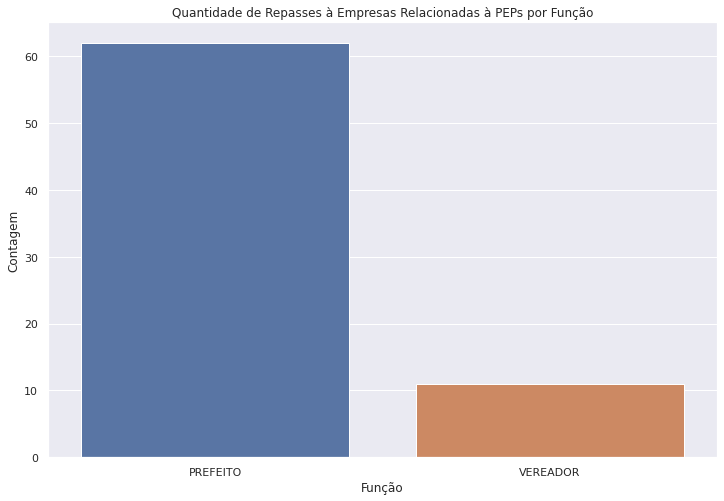

In [50]:
ax = sns.countplot(data=empresas_peps.sort_values('Funcao_PEP'), x='Funcao_PEP')

ax.set(title='Quantidade de Repasses à Empresas Relacionadas à PEPs por Função')
ax.set(xlabel='Função', ylabel='Contagem')

#### Despesas com Empresas Relacionadas à PEPs por Função

[Text(0.5, 0, 'Função'), Text(0, 0.5, 'Contagem')]

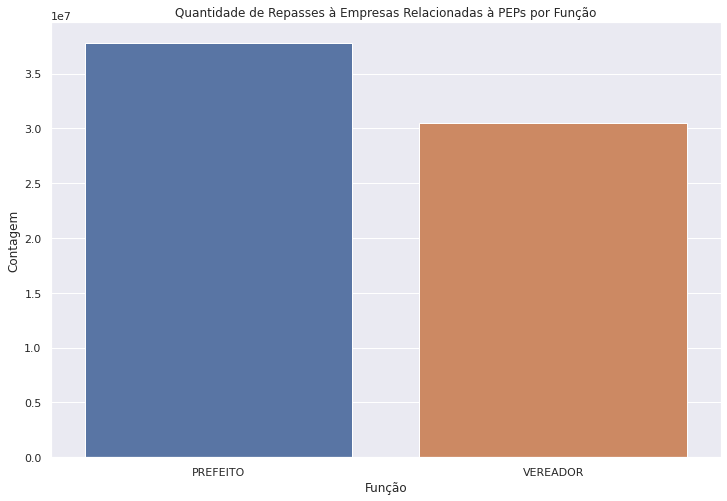

In [51]:
soma_valores_empresas_peps_funcao = empresas_peps.groupby('Funcao_PEP')['Valor_Total'].sum().reset_index()
soma_valores_empresas_peps_funcao = soma_valores_empresas_peps_funcao.sort_values('Funcao_PEP')
ax = sns.barplot(data=soma_valores_empresas_peps_funcao, x='Funcao_PEP', y='Valor_Total')

ax.set(title='Quantidade de Repasses à Empresas Relacionadas à PEPs por Função')
ax.set(xlabel='Função', ylabel='Contagem')

#### Distribuição de Valores Recebidos por Empresas relacionada à PEPs por Função

[Text(0.5, 0, 'Função'), Text(0, 0.5, 'Valor Recebido')]

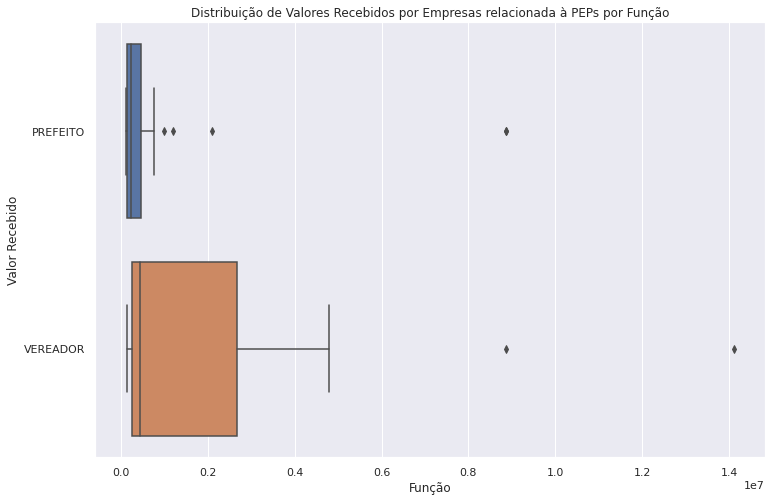

In [52]:
ax = sns.boxplot(data=empresas_peps.sort_values('Funcao_PEP'), x="Valor_Total", y="Funcao_PEP")

ax.set(title='Distribuição de Valores Recebidos por Empresas relacionada à PEPs por Função')
ax.set(xlabel='Função', ylabel='Valor Recebido')

#### PEPS com maiores Recebimentos

In [53]:
valores_por_pep = empresas_peps.groupby('Nome_PEP')['Valor_Total'].sum().sort_values(ascending=False).reset_index()

[Text(0.5, 0, 'Valores Recebidos'), Text(0, 0.5, 'PEPs')]

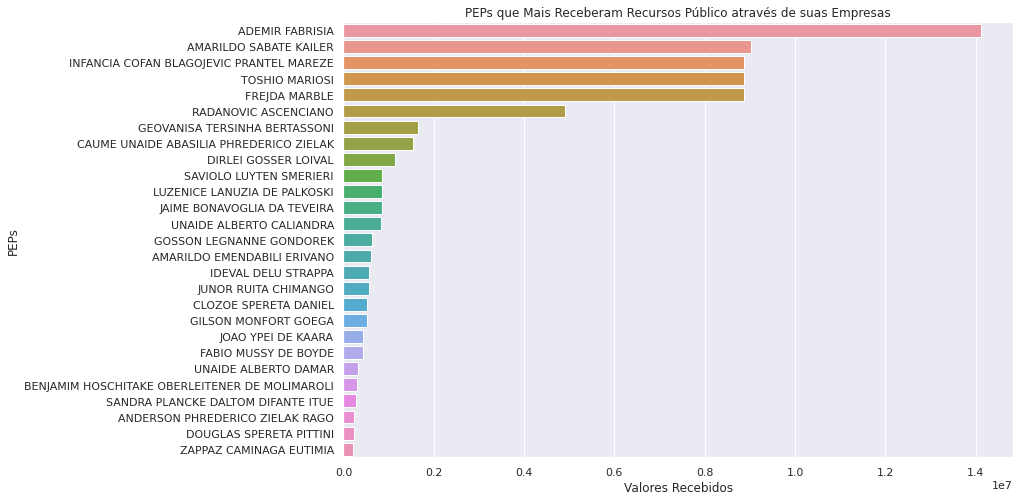

In [54]:
ax = sns.barplot(data=valores_por_pep, x='Valor_Total', y='Nome_PEP')

ax.set(title='PEPs que Mais Receberam Recursos Público através de suas Empresas')
ax.set(xlabel='Valores Recebidos', ylabel='PEPs')

### Salvar dados

In [55]:
arquivo_saida = 'empresas_peps.csv'
filepath = os.path.join(diretorio_saida_dados, arquivo_saida)
empresas_peps.to_csv(filepath, index=False)

## Consultar Empresas Relacionadas com Pessoas Politicamente Expostas que Receberam Recursos dos Municípios que Possuem Mandatos

In [56]:
empresas_peps_mesmo_municipio = empresas_peps[empresas_peps['Municipio_PEP'] == empresas_peps['Nome_Municipio_Ficticio']]

In [57]:
empresas_peps_mesmo_municipio.shape

(11, 24)

In [58]:
empresas_peps_mesmo_municipio.sample(5)

,Nome_Municipio_Ficticio,CNPJ_Empresa_Beneficiaria,Razao_Social_Empresa_Beneficiaria,Valor_Total,CNPJ_RFB,Razao_Social_RFB,Situacao_Cadastral_RFB,Data_Situacao_Cadastral_RFB,Codigo_Natureza_Juridica_RFB,Data_Inicio_Atividade_RFB,...,CPF_Socio_RFB,Data_Entrada_Socio_RFB,Nome_PEP,CPF_PEP,Funcao_PEP,Data_Inicio_PEP,Data_Fim_PEP,Data_Carencia_PEP,Municipio_PEP,UF_PEP
32,ALVERNE,47817109002513,CLAIRE SUPERMERCADO,311980.65,47817109002513,CLAIRE SUPERMERCADO,ATIVA,20200101,2062,20050723,...,***199388**,20200101,UNAIDE ALBERTO DAMAR,***199388**,VEREADOR,2017-01-01,2020-12-31,2025-12-31,ALVERNE,SP
0,KANDELMAN,51653764000156,ROBERTS INFORMACAO EPP,14121381.99,51653764000156,ROBERTS INFORMACAO EPP,ATIVA,20200101,3999,19661022,...,***708958**,20200101,ADEMIR FABRISIA,***708958**,VEREADOR,2017-01-01,2020-12-31,2025-12-31,KANDELMAN,SP
15,KNOLL,18941225000172,CSENGE CONFECCOES EIRELLI,555209.93,18941225000172,CSENGE CONFECCOES EIRELLI,ATIVA,20200101,2232,20120324,...,***969658**,20200101,JUNOR RUITA CHIMANGO,***969658**,VEREADOR,2017-01-01,2020-12-31,2025-12-31,KNOLL,SP
6,SOLIZ,55815300000213,AMINE IMOBILIARIOS,1193598.13,55815300000213,AMINE IMOBILIARIOS,ATIVA,20200101,3999,19870728,...,***890658**,20200101,AMARILDO SABATE KAILER,***890658**,PREFEITO,2017-01-01,2020-12-31,2025-12-31,SOLIZ,SP
41,BREIA,10240793000137,JOAO LUCAS ELETRONICOS SA,225281.82,10240793000137,JOAO LUCAS ELETRONICOS SA,ATIVA,20200101,3999,20130111,...,***502138**,20200101,CAUME UNAIDE ABASILIA PHREDERICO ZIELAK,***502138**,PREFEITO,2017-01-01,2020-12-31,2025-12-31,BREIA,SP


### Visualização

#### Quantidade de Repasses à Empresas Relacionadas à PEPs por Função

[Text(0.5, 0, 'Função'), Text(0, 0.5, 'Contagem')]

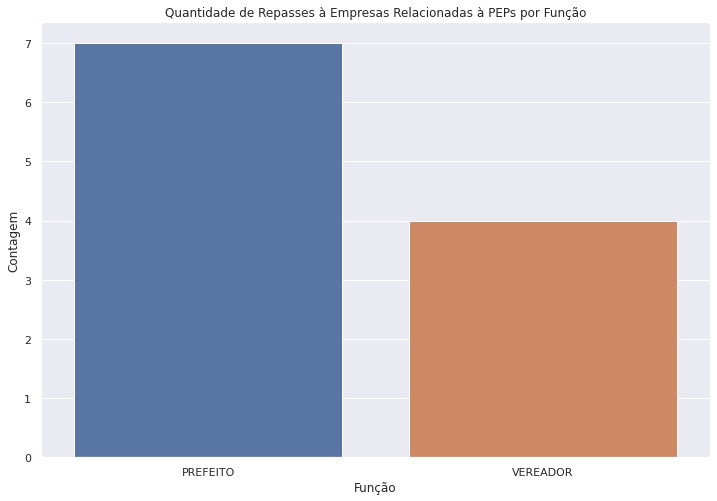

In [59]:
ax = sns.countplot(data=empresas_peps_mesmo_municipio.sort_values('Funcao_PEP'), x='Funcao_PEP')

ax.set(title='Quantidade de Repasses à Empresas Relacionadas à PEPs por Função')
ax.set(xlabel='Função', ylabel='Contagem')

#### Despesas com Empresas Relacionadas à PEPs por Função

[Text(0.5, 0, 'Função'), Text(0, 0.5, 'Contagem')]

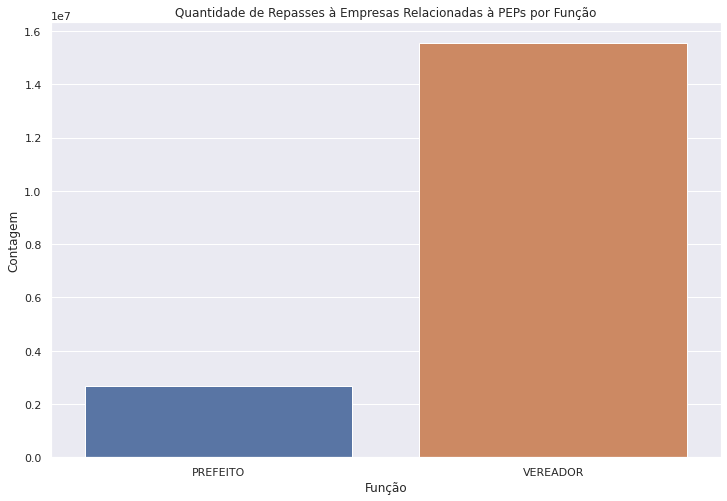

In [60]:
soma_valores_empresas_peps_funcao = empresas_peps_mesmo_municipio.groupby('Funcao_PEP')['Valor_Total'].sum().reset_index()
soma_valores_empresas_peps_funcao = soma_valores_empresas_peps_funcao.sort_values('Funcao_PEP')
ax = sns.barplot(data=soma_valores_empresas_peps_funcao, x='Funcao_PEP', y='Valor_Total')

ax.set(title='Quantidade de Repasses à Empresas Relacionadas à PEPs por Função')
ax.set(xlabel='Função', ylabel='Contagem')

#### Distribuição de Valores Recebidos por Empresas relacionada à PEPs por Função

[Text(0.5, 0, 'Função'), Text(0, 0.5, 'Valor Recebido')]

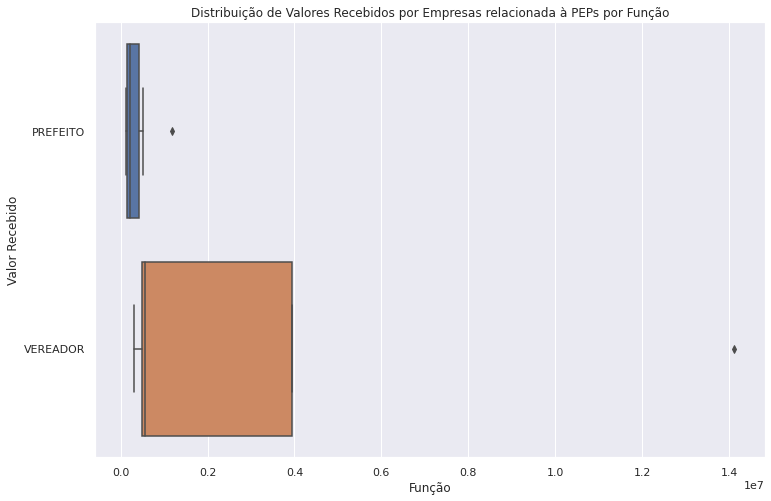

In [61]:
ax = sns.boxplot(data=empresas_peps_mesmo_municipio.sort_values('Funcao_PEP'), x="Valor_Total", y="Funcao_PEP")

ax.set(title='Distribuição de Valores Recebidos por Empresas relacionada à PEPs por Função')
ax.set(xlabel='Função', ylabel='Valor Recebido')

#### PEPS com maiores Recebimentos

In [62]:
valores_por_pep = empresas_peps_mesmo_municipio.groupby('Nome_PEP')['Valor_Total'].sum().sort_values(ascending=False).reset_index()

[Text(0.5, 0, 'Valores Recebidos'), Text(0, 0.5, 'PEPs')]

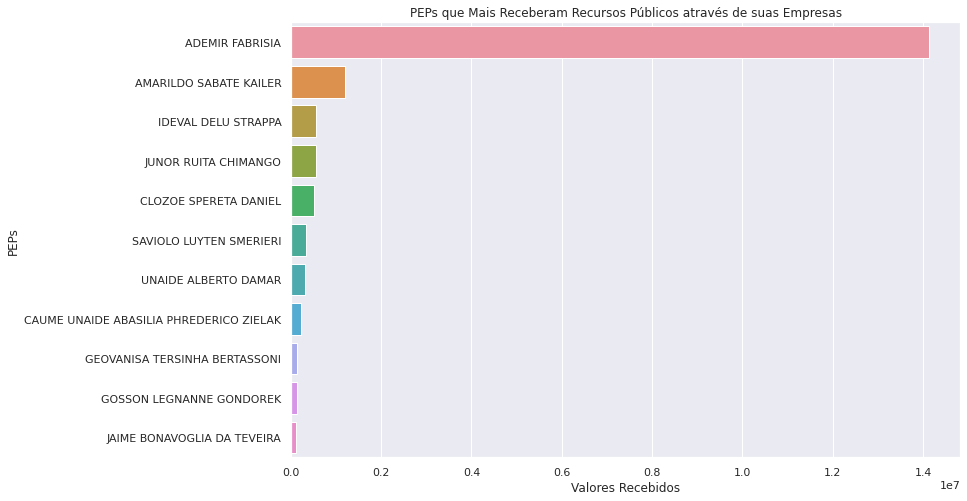

In [63]:
ax = sns.barplot(data=valores_por_pep, x='Valor_Total', y='Nome_PEP')

ax.set(title='PEPs que Mais Receberam Recursos Públicos através de suas Empresas')
ax.set(xlabel='Valores Recebidos', ylabel='PEPs')

### Salvar dados

In [64]:
arquivo_saida = 'empresas_peps_mesmo_municipio.csv'
filepath = os.path.join(diretorio_saida_dados, arquivo_saida)
empresas_peps_mesmo_municipio.to_csv(filepath, index=False)

# Visualização

## Mapa de Localização de Empresas relacionadas à PEPs

Essa visualização não é possível via PDF

In [65]:
arquivo_municipios = 'Municipios_SP_paridade.csv'
filepath_arquivo_municipios = os.path.join(diretorio_dados, arquivo_municipios)
municipios = pd.read_csv(filepath_arquivo_municipios, sep='|')

empresas_peps_coord = pd.merge(empresas_peps, municipios, how="inner", left_on='Nome_Municipio_Ficticio', right_on='Municipio_ficticio')

In [66]:
mapa_plot = folium.Map(location=[empresas_peps_coord.Latitude.mean(), empresas_peps_coord.Longitude.mean()], zoom_start=7, control_scale=True)
for index, location_info in empresas_peps_coord.iterrows():
    description = "A empresa " + location_info["Razao_Social_Empresa_Beneficiaria"] + " (CNPJ " + location_info["CNPJ_Empresa_Beneficiaria"] + "), relacionada ao PEP " + location_info["Nome_PEP"] + ", recebeu R$ " + str(location_info["Valor_Total"])
    description.splitlines(True)
    folium.Marker(
        [location_info["Latitude"], location_info["Longitude"]],
        popup=description,
        tooltip=description,
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(mapa_plot)
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Mapa (fictício) de empresas relacionadas com PEPs</b></h3>
             '''
mapa_plot.get_root().html.add_child(folium.Element(title_html))
mapa_plot